In [ ]:
!pip3 install openai

In [ ]:
example_input_table = "col : name | city | hospital beds | operating rooms | total | trauma designation | affiliation | notes row 1 : alamance regional medical center | burlington | 238 | 15 | 253 | - | cone | - row 2 : albemarle hospital | elizabeth city | 182 | 13 | 195 | - | vidant | - row 3 : alleghany memorial hospital | sparta | 41 | 2 | 43 | - | qhr | - row 4 : angel medical center | franklin | 59 | 7 | 66 | - | mission | - row 5 : annie penn hospital | reidsville | 110 | 6 | 116 | - | cone | - row 6 : anson community hospital | wadesboro | 147 | 3 | 150 | - | chs | - row 7 : ashe memorial hospital | jefferson | 136 | 3 | 139 | - | novant | - row 8 : asheville specialty hospital | asheville | 34 | 0 | 34 | - | - | - row 9 : vidant beaufort hospital | washington | 142 | 7 | 149 | - | vidant | - row 10 : vidant bertie hospital | windsor | 6 | 2 | 8 | - | vidant | - row 11 : betsy johnson regional hospital | dunn | 101 | 6 | 107 | - | hhs | - row 12 : blowing rock hospital | blowing rock | 100 | 2 | 102 | - | arhs | - row 13 : blue ridge regional hospital | spruce pine | 46 | 4 | 50 | - | mission | - row 14 : novant health brunswick medical center | supply | 60 | 6 | 66 | - | novant | - row 15 : caldwell memorial hospital | lenoir | 110 | 10 | 120 | - | unc | - row 16 : cape fear valley medical center | fayetteville | 600 | 22 | 622 | - | cape fear | - row 17 : cape fear valley-bladen county hospital | elizabethtown | 58 | 2 | 60 | - | cape fear | - row 18 : carolinaeast medical center | new bern | 350 | 20 | 370 | - | - | - row 19 : carolinas medical center-pineville | charlotte | 305 | 26 | 331 | - | chs | - row 20 : carolinas medical center-lincoln | lincolnton | 101 | 6 | 107 | - | chs | - row 21 : carolinas medical center-northeast | concord | 457 | 25 | 482 | level iii | chs | - row 22 : carolinas medical center-union | monroe | 227 | 9 | 236 | - | chs | - row 23 : carolinas medical center-university | charlotte | 130 | 15 | 145 | - | chs | - row 24 : carolinas medical center/center for mental health | charlotte | 874 | 51 | 925 | level i | chs | secondary campus of the university of north carolina school of medicine row 25 : carolinas rehabilitation mt. holly | belmont | 40 | 0 | 40 | - | chs | - row 26 : charles a. cannon, jr. memorial hospital | linville | 50 | 3 | 50 | - | arhs | - row 27 : vidant chowan hospital | edenton | 89 | 4 | 93 | - | vidant | - row 28 : cone health | greensboro | 907 | 62 | 969 | level ii | cone | - row 29 : vidant duplin hospital | kenansville | 101 | 3 | 104 | - | vidant | - row 30 : durham regional hospital | durham | 369 | 19 | 388 | - | duke | - row 31 : firsthealth moore regional hospital and pinehurst treatment | pinehurst | 372 | 19 | 391 | - | firsthealth | - row 32 : firsthealth moore regional hospital hoke campus | pinehurst, north carolina | 8 | 1 | 9 | - | firsthealth | - row 33 : firsthealth richmond memorial hospital | rockingham | 150 | 6 | 156 | - | firsthealth | -"
example_input_question = "what is the only hospital to have 6 hospital beds?"
example_answer = "vidant bertie hospital"
# more examples can be downloaded at: https://huggingface.co/datasets/TIGER-Lab/SKGInstruct/blob/main/skginstruct_test_file_13b_34b.json (WikiTQ file split)

Example table (visualized)

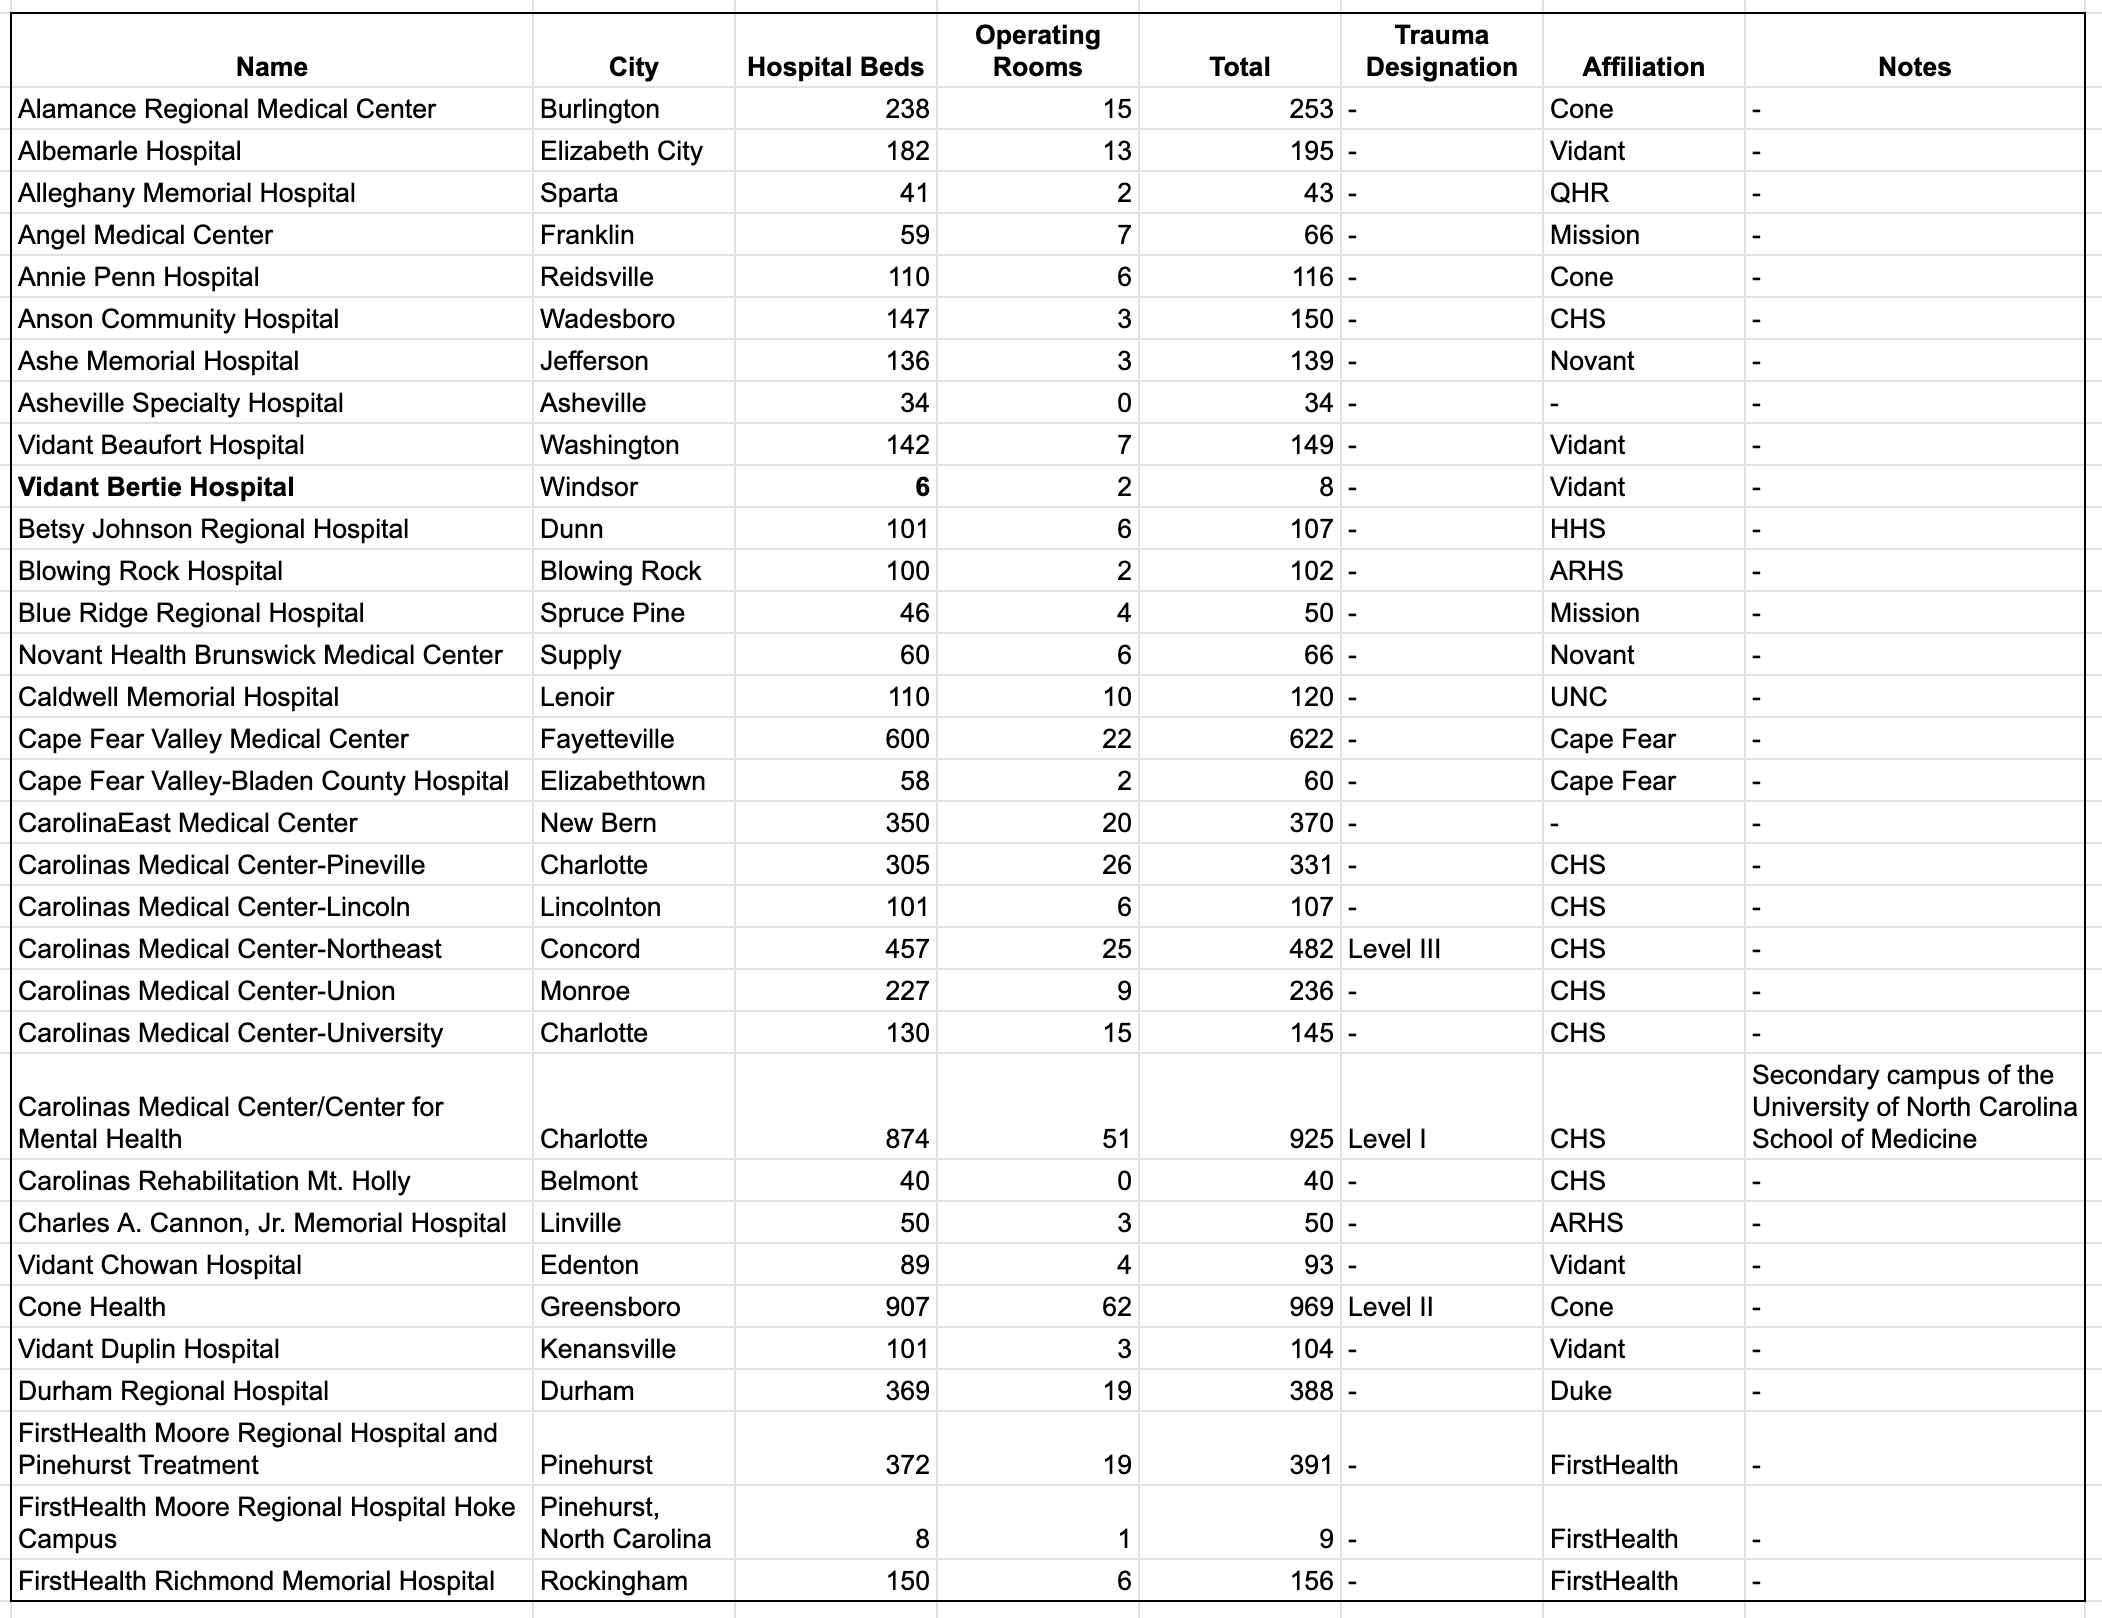

In [ ]:
import json
import openai
import re
import os
import numpy as np
import argparse
import random
import time
import pandas as pd
from tqdm import tqdm
import time
import glob
from openai import OpenAI


# ----  PsuedoCode parsing operations --- #

# remove bracelet, split into operators and columns
def preprocess_filters(list_of_raw_filters):
    out = []
    for value in list_of_raw_filters:
        if value[0] == '[' and value[-1] == ']':
            value = value[1:-1]
        elif value[-1] == ',':
            out.append(value.replace('[','').replace(']',''))
            value = 'OR'
        else:
            value = value.strip()
        out.append(value)
    return out

def parse_pseudo_filter_code(code):
    result = code.split(']\nFilters: ') # take into account only first
    try:
        columns, the_rest = result[0], result[1]
    except:
        if 'Filters:' not in code:
            columns = code.replace(']', '').replace('\n','').strip()
            the_rest = ''
        else:
            result = code.split('Filters:')
            columns, the_rest = result[0], result[1]
            columns = columns.replace(']', '').replace('\n','')
            the_rest = the_rest.strip()
    columns = columns.replace('Columns: [', '')
    columns = [x.strip() for x in columns.split(',')]
    if the_rest == '': # No filter
        filters = []
    else:
        filters = preprocess_filters(the_rest.split(' '))
    return columns, filters

def validate_and_format_filters(raw_filtered_columns, raw_operators, full_cols, full_row_of_rows):
    # format operators
    list_of_operators = []
    idx = 0
    list_of_valid_operators = ['==', 'includes', '!=', '>', '<', '<=', '>=']
    while idx < len(raw_operators):
        raw = raw_operators[idx]
        if raw in ['', 'AND', 'and', 'OR', 'or']:
            idx += 1
            continue
        if idx < (len(raw_operators) - 2) and raw in full_cols and raw_operators[idx+1] in list_of_valid_operators: # has to match
            init_operator = {'column_name': raw, 'operator': raw_operators[idx+1], 'value': raw_operators[idx+2]}
            if raw != 'None' and raw_operators[idx+2] != 'None': # skip if None
                list_of_operators.append(init_operator)
        idx += 3
    filter_colnames = [x['column_name'] for x in list_of_operators]
    for x in filter_colnames: # add colnames in filter if that wasn't there in initial columns.
        if x not in raw_filtered_columns:
            raw_filtered_columns.append(x)
    if full_cols[0] not in raw_filtered_columns:
        raw_filtered_columns = [full_cols[0]] + raw_filtered_columns # add first column if not present.
    if len(raw_filtered_columns) == 1 and len(full_cols) != 1: #if there's only one column, add the last one
        raw_filtered_columns.append(full_cols[-1])
    # validate raw_filtered_columns
    final_filtered_columns = []
    raw_filtered_columns = remove_newline_and_convert_to_camelcase(raw_filtered_columns)
    for x in raw_filtered_columns:
        if x in full_cols:
            final_filtered_columns.append(x)
    if len(list_of_operators) > 10: # if there's too many, discard them
        list_of_operators = []
    return final_filtered_columns, list_of_operators

def maybe_normalize_float(span):
    if span and (re.match(r"^[+-][0-9]+[.]?[0-9]*$", span)
                 or (re.match(r"^[0-9]*[.]?[0-9]*$", span))) and span != '.':
        # FIXME: We did this(instead of try except) to convert a string into a float
        #  since the try catch will lead to an error when using 8 V100 gpus with cuda 11.0,
        #  and we still don't know why that could happen....
        return str(float(span))
    else:
        return span

def eval_ex_match(pred, gold_result):
    pred = [span.strip() for span in pred.split(', ')]
    gold_result = [span.strip() for span in gold_result.split(', ')]
    clean_float = True
    if clean_float:
        pred = [maybe_normalize_float(span) for span in pred]
        gold_result = [maybe_normalize_float(span) for span in gold_result]
    return sorted(pred) == sorted(gold_result)

def eval_lin_match(pred, gold):
    pred = pred.replace('.','').replace(',','').replace('"','').replace("'",'').strip()
    gold = gold.replace('.','').replace(',','').replace('"','').replace("'",'').strip()
    return eval_ex_match(pred.lower(), gold.lower())

def match_condition(operator_symbol, true_value, match_value):
    if true_value == 'Null':
        true_value = ''
    if match_value == 'None':
        return True

    if operator_symbol == '==':
        if eval_lin_match(true_value, match_value):
            return True
    elif operator_symbol == 'includes':
        if match_value.lower().strip() in true_value.lower().strip():
            return True
    elif operator_symbol == '!=':
        if not eval_lin_match(true_value, match_value):
            return True
    elif operator_symbol in ['>', '<', '>=', '<=']: # only consider integers
        try:
            value1, value2 = float(true_value), float(match_value)
            if (operator_symbol == '>' and value1 > value2) or (operator_symbol == '<' and value1 < value2) or (operator_symbol == '>=' and value1 >= value2) or (operator_symbol == '<=' and value1 <= value2):
                return True
        except ValueError:
            return True # skip this
    return False

def apply_operators(table, operators):
    headers = table['header']
    rows = table['rows']
    new_row_idxs = []
    for operator in operators:
        operator_index = headers.index(operator['column_name'])
        for i, row in enumerate(rows):
            if match_condition(operator['operator'], row[operator_index], operator['value']):
                if i not in new_row_idxs:
                    new_row_idxs.append(i)
    new_rows = []
    for i, row in enumerate(rows):
        if i in new_row_idxs:
            new_rows.append(row)
    if new_rows == []: # revert if filtered output has None
        new_rows = rows
    new_table = {'header': headers, 'rows': new_rows}
    return new_table


def reorder_table(table, ordering):
    new_header = []
    row_cnt = len(table['rows'])
    new_row = [[] for _ in range(row_cnt)]
    for i in ordering:
        new_header.append(table['header'][i])
        for rc in range(row_cnt):
            new_row[rc].append(table['rows'][rc][i])
    return {'header': new_header, 'rows': new_row}


# --- table formatting functions --- #

def linearize_table(table_dict):
    columns = ' | '.join(table_dict['header']).lower()
    row_text = ''
    for i, row in enumerate(table_dict['rows']):
        row_text += f' row {i+1} : '
        row_text += ' | '.join(row)
    row_text = row_text.lower()
    linearized_table = f"col: {columns} {row_text}"
    return linearized_table

def shrink_table(ordering, question, original_linearized_table):
    output = get_table(original_linearized_table)
    cols = output['header']
    cols = remove_newline_and_convert_to_camelcase(cols)
    rows = output['rows']
    row_of_rows = [[x[k] for x in rows] for k in range(len(cols))]
    set_col_vals = [list(set(x)) for x in row_of_rows]
    raw_filtered_columns, raw_operators = parse_pseudo_filter_code(ordering)
    filtered_columns, operators = validate_and_format_filters(raw_filtered_columns, raw_operators, cols, row_of_rows)
    ordering = [cols.index(x) for x in filtered_columns]
    original_table = {'header': cols, 'rows': rows} # replace cols with remove newline and camelcase
    reordered_table = reorder_table(original_table, ordering)
    filtered_reordered_table = apply_operators(reordered_table, operators)
    filtered_reordered_linearized_table = linearize_table(filtered_reordered_table)
    return filtered_reordered_linearized_table

def get_table(texts):
    table_info = texts.split(' row 1 : ')
    columns = table_info[0].replace('col : ','').split(' | ')
    rows_raw = table_info[1]
    rows = []
    row_idx = 2
    while True:
        try:
            index = rows_raw.index(f" row {row_idx} : ")
            row = rows_raw[:index]
            rows.append(row.split(' | '))
            rows_raw = rows_raw[index:].replace(f' row {row_idx} : ','')
            row_idx += 1
        except ValueError:
            # exception: if last row, last val consists of Null, we need to add space
            if rows_raw[-1] == '|':
                rows_raw = rows_raw + ' '
            last_row = rows_raw.split(' | ')
            while len(last_row) != len(columns):
                last_row.append(' ')
            rows.append(last_row)
            break

    if len(columns) != list(set([len(x) for x in rows]))[0]:
        print(f"length of column {len(columns)} and rows {[len(x) for x in rows]} doesn't match!!!")
        import pdb; pdb.set_trace()
    return {'header': columns, 'rows': rows}

def remove_newline_and_convert_to_camelcase(headers):
    new_headers = []
    for value in headers:
        value = value.strip().replace('  ', ' ').replace('  ', ' ').replace('  ',' ')
        value = value.replace(' ', '_')
        value = value.replace('\n', '_')
        value = value.replace('__', '_').replace('__','_')
        new_headers.append(value)
    return new_headers

def sql_subfunc_linearize_headers_with_values(list_of_headers, list_of_values):
    out = ''
    for i, zipped in enumerate(zip(list_of_headers, list_of_values)):
        x, v_ = zipped
        v = []
        for imsi in v_:
            if imsi == '':
                v.append('Null')
            else:
                v.append(imsi)
        index = i + 1
        if len(v) > 5:
            v = v[:4] + ['...'] + v[-1:]

        values_list = ', '.join(v)
        out += f"{x}: {values_list}\n"
    return out

def order_preserved_set(list_of_values):
    out = []
    for x in list_of_values:
        if x not in out:
            out.append(x)
    return out


def run_gpt3_api(api_key, input_text):
    client = OpenAI(api_key=api_key)
    system_prompt = 'You are an AI assistant that specializes in analyzing and reasoning over structured information. '
    system_prompt = system_prompt + 'You will be given a task, optionally with some structured knowledge input. '
    system_prompt = system_prompt + 'Your answer must strictly adhere to the output format, if specified.'
    system_prompt = system_prompt + ' Only respond with the answer, do not say any word or explain.'
    retry = True
    while retry:
        try:
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": input_text},
                ],
                n=1,  # Generate 1 output per attempt
                stop=None,
                temperature=0,
            )
            response_text = response.choices[0].message.content.strip()
        except Exception as e:
            error = str(e)
            print(f"Error!! {error}\n")
            if "overloaded with other requests." in error:
                continue
            else:
                print("Sleeping 10 sec and trying again.")
                time.sleep(10)
                continue
        retry = False
    return response_text

def make_gpt3_prompt(question, linearized_table):
    text = f"Use the information in the following table to answer the question. table:\n\n{linearized_table}\n\n\n"
    text = text + f"question:\n\n{question}. Only respond with the answer, do not say any word or explain."
    return text

def make_filtering_prompt(question, linearized_table):
    table_info = get_table(linearized_table)
    headers = remove_newline_and_convert_to_camelcase(table_info['header'])
    rows = table_info['rows']
    row_of_rows = [[x[k] for x in rows] for k in range(len(headers))]
    set_col_vals = row_of_rows
    linearized_table = sql_subfunc_linearize_headers_with_values(headers, set_col_vals)
    if len(headers) <= 5:
        shortened_headers = ', '.join(headers)
    elif len(headers) > 5:
        shortened_headers = ', '.join(headers[:4])
        shortened_headers += ', ..., '
        shortened_headers += headers[-1]
    raw = 'Given the table which consists of a set of column names followed by real values separated by comma, your job is to write a simple pseudoquery '
    raw += 'that reduces the table content using only "Columns" and "Filters", given a user’s request.'
    raw += f'\n\n[Table - column_names: list_of_values]\n{linearized_table}'
    raw += f"\n\nWrite a simple pseudocode that reduces the table, adhering to the following format:\n\nColumns: list of selected columns among [{shortened_headers}]\n"
    raw += "Filters: [column_name] [None, ==, !=, <, >, <=, >=, includes] [value] (OR [column_name] ... )\n\n"
    raw += "The output format should only consist of list of column names, operators and filters, each wrapped by brackets [], e.g., Columns: [aa, bb]\nFilters: [aa] [==] [xx]. Multiple filters, followed by [OR] [None, ==, ...] [value] are allowed, if necessary. "
    raw += "Output appropriate column names and filters in the above format. All the relevant column names in the table to help answer the question should "
    raw += "be included in the output. question: "
    raw += f"{question}. Only respond with the following format, do not say any word or explain.\n\n"
    return raw

In [ ]:
input_table = example_input_table
question = example_input_question
api_key = 'sk-write-your-api-key-here'

In [ ]:
# direct RAG option
print(f"Option [direct] chosen.")
tableqa_prompt = make_gpt3_prompt(question, input_table)
print(f"##### Direct option. Conduct table QA based on direct tables. #####\n\n[Input table QA]\n{tableqa_prompt}\n")
final_answer = run_gpt3_api(api_key, tableqa_prompt)
print(f"##### Final answer: {final_answer}")
print(f"Answer is correct: {final_answer == example_answer}")
print('Done.')

Option [direct] chosen.
##### Direct option. Conduct table QA based on direct tables. #####

[Input table QA]
Use the information in the following table to answer the question. table:

col : name | city | hospital beds | operating rooms | total | trauma designation | affiliation | notes row 1 : alamance regional medical center | burlington | 238 | 15 | 253 | - | cone | - row 2 : albemarle hospital | elizabeth city | 182 | 13 | 195 | - | vidant | - row 3 : alleghany memorial hospital | sparta | 41 | 2 | 43 | - | qhr | - row 4 : angel medical center | franklin | 59 | 7 | 66 | - | mission | - row 5 : annie penn hospital | reidsville | 110 | 6 | 116 | - | cone | - row 6 : anson community hospital | wadesboro | 147 | 3 | 150 | - | chs | - row 7 : ashe memorial hospital | jefferson | 136 | 3 | 139 | - | novant | - row 8 : asheville specialty hospital | asheville | 34 | 0 | 34 | - | - | - row 9 : vidant beaufort hospital | washington | 142 | 7 | 149 | - | vidant | - row 10 : vidant bertie hos

In [ ]:
# Filter code option
print(f"Option [filter] chosen.")
filtering_prompt = make_filtering_prompt(question, input_table)
print(f"##### Stage 1. Make prompt that outputs table filtering pseudocode #####\n\n[Input prompt]\n{filtering_prompt}\n")
pseudocode_output = run_gpt3_api(api_key, filtering_prompt)
print(f"##### >>> Stage 1 After gpt3 inference #####\n\n[output]\n{pseudocode_output}")
shrinked_table = shrink_table(pseudocode_output, question, input_table)
print(f"##### Stage 2. Parse pseudocodes and shrink table #####\n\n[Shrinked table]\n{shrinked_table}\n")
tableqa_prompt = make_gpt3_prompt(question, shrinked_table)
print(f"##### Stage 3. Conduct table QA based on shrinked tables. #####\n\n[Input table QA]\n{tableqa_prompt}\n")
final_answer = run_gpt3_api(api_key, tableqa_prompt)
print(f"##### Final answer: {final_answer}")
print(f"Answer is correct: {final_answer == example_answer}")
print('Done.')

Option [filter] chosen.
##### Stage 1. Make prompt that outputs table filtering pseudocode #####

[Input prompt]
Given the table which consists of a set of column names followed by real values separated by comma, your job is to write a simple pseudoquery that reduces the table content using only "Columns" and "Filters", given a user’s request.

[Table - column_names: list_of_values]
name: alamance regional medical center, albemarle hospital, alleghany memorial hospital, angel medical center, ..., firsthealth richmond memorial hospital
city: burlington, elizabeth city, sparta, franklin, ..., rockingham
hospital_beds: 238, 182, 41, 59, ..., 150
operating_rooms: 15, 13, 2, 7, ..., 6
total: 253, 195, 43, 66, ..., 156
trauma_designation: -, -, -, -, ..., -
affiliation: cone, vidant, qhr, mission, ..., firsthealth
notes: -, -, -, -, ..., -


Write a simple pseudocode that reduces the table, adhering to the following format:

Columns: list of selected columns among [name, city, hospital_beds,